### Aluno: Lucas Rodrigues Aragão (538390)

O enunciado permite o uso de implementações já feitas, nesse caso escolhi a do sklearn pela familiaridade com a biblioteca.

Com isso, o que deve ser implementado aqui são as funções auxiliares.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.preprocessing import StandardScaler

## Criando o grid search para encontrar o melhor conjunto de hiperparametros para o modelo

In [2]:
def test_hyperparameter_rec(hyperparameter_list, model, x_train, x_teste, y_train, y_teste, scaler_y = None, hyperparameter=0, hyperparameters_atuais=[]):
    """
    essa funcao calcula recursivamente as metricas de avaliacao para todas as combinacoes de hiperparametros possiveis e retorna elas em formato de lista
    
    """
    
    if len(hyperparameters_atuais) == len(hyperparameter_list):
        if isinstance(model, MLPRegressor):
            modelo = MLPRegressor(**dict(hyperparameters_atuais))
        else:
            modelo = MLPClassifier(**dict(hyperparameters_atuais))

        modelo.fit(x_train, y_train)
        predictions = modelo.predict(x_teste)

        if isinstance(model, MLPRegressor):
            predictions_desnormalizado = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).ravel()
            rmse = np.sqrt(np.mean((y_teste - predictions_desnormalizado) ** 2))
            return [[rmse, hyperparameters_atuais]]  
        else:
            accuracy = np.mean(predictions == y_teste)
            return [[accuracy, hyperparameters_atuais]]  

    resultados = []
    for element in hyperparameter_list[hyperparameter][1]:
        hyperparameters_temp = hyperparameters_atuais + [(hyperparameter_list[hyperparameter][0], element)]
        res = test_hyperparameter_rec(hyperparameter_list, model, x_train, x_teste, y_train, y_teste, scaler_y, hyperparameter=hyperparameter + 1, hyperparameters_atuais=hyperparameters_temp)
        resultados.extend(res)  
    return resultados

def kfold_com_grid_search(model, features_data, label_data, hyperparameters_list, num_folds):
    """
    essa funcao calcula as avaliacoes para todas as combinacoes possiveis, variando os conjuntos de treino e validacao
    ao final ela retorna o modelo com o melhor conjunto de hiperparametros e o valor da metrica de avaliacao obtida
    """
    tamanho_particoes = int(np.ceil(len(features_data) / num_folds))

    lista_avaliacoes = []

    for i in range(num_folds):
        inicio = i * tamanho_particoes
        fim = min((i + 1) * tamanho_particoes, len(features_data))

        x_teste = features_data.iloc[inicio:fim]
        y_teste = label_data.iloc[inicio:fim]

        x_train_fold = features_data.drop(features_data.index[inicio:fim])
        y_train_fold = label_data.drop(label_data.index[inicio:fim])

        scaler_x = StandardScaler()
        x_train_fold_normalizado = pd.DataFrame(scaler_x.fit_transform(x_train_fold), columns=x_train_fold.columns, index=x_train_fold.index)
        x_train_fold = x_train_fold_normalizado.copy()
        x_teste_normalizado = pd.DataFrame(scaler_x.transform(x_teste), columns=x_teste.columns, index=x_teste.index)
        x_teste = x_teste_normalizado.copy()

        if isinstance(model, MLPRegressor):
            scaler_y = StandardScaler()
            y_train_fold_normalizado = scaler_y.fit_transform(y_train_fold.values.reshape(-1, 1))
            y_train_fold = y_train_fold_normalizado.ravel()
            avaliacoes = test_hyperparameter_rec(hyperparameter_list=hyperparameters_list, model=model, x_train=x_train_fold, x_teste=x_teste, y_train=y_train_fold, y_teste=y_teste, scaler_y= scaler_y)
        else:
            avaliacoes = test_hyperparameter_rec(hyperparameter_list=hyperparameters_list, model=model, x_train=x_train_fold, x_teste=x_teste, y_train=y_train_fold, y_teste=y_teste)

        lista_avaliacoes.extend(avaliacoes)

    combinacoes = {}

    for resultado in lista_avaliacoes:
        score, params = resultado
        params_tuple = tuple(params)  
        if params_tuple not in combinacoes:
            combinacoes[params_tuple] = []
        combinacoes[params_tuple].append(score)

    medias_comb = {param: np.mean(scores) for param, scores in combinacoes.items()}

    if isinstance(model, MLPRegressor):
        melhor_comb = min(medias_comb, key=medias_comb.get)  
    else:
        melhor_comb = max(medias_comb, key=medias_comb.get)  

    return melhor_comb, medias_comb[melhor_comb]


def kfold_padrao(model, hyperparameters, features_data, label_data, num_folds):
    """
    essa funcao faz o kfold simples e ao final plota o grafico das diferentes particoes
    """
    tamanho_particoes = int(np.ceil(len(features_data) / num_folds))
    curvas = []
    rmses = []
    for i in range(num_folds):
        if isinstance(model, MLPRegressor):
            model = MLPRegressor(**dict(hyperparameters))
        else:
            model = MLPClassifier(**dict(hyperparameters))
        inicio = i * tamanho_particoes
        fim = min((i + 1) * tamanho_particoes, len(features_data))

        x_teste = features_data.iloc[inicio:fim]
        y_teste = label_data.iloc[inicio:fim]

        x_train_fold = features_data.drop(features_data.index[inicio:fim])
        y_train_fold = label_data.drop(label_data.index[inicio:fim])

        scaler_x = StandardScaler()
        x_train_fold_normalizado = pd.DataFrame(scaler_x.fit_transform(x_train_fold), columns=x_train_fold.columns, index=x_train_fold.index)
        x_train_fold = x_train_fold_normalizado.copy()
        x_teste_normalizado = pd.DataFrame(scaler_x.transform(x_teste), columns=x_teste.columns, index=x_teste.index)
        x_teste = x_teste_normalizado.copy()

        if isinstance(model, MLPRegressor):
            scaler_y = StandardScaler()
            y_train_fold_normalizado = scaler_y.fit_transform(y_train_fold.values.reshape(-1, 1))
            y_train_fold = y_train_fold_normalizado.ravel()
            y_teste_normalizado = scaler_y.transform(y_teste.values.reshape(-1, 1))
            y_teste = y_teste_normalizado.ravel()
        
        model.fit(x_train_fold_normalizado, y_train_fold)
        curvas.append(model.loss_curve_)

    fig, axes  = plt.subplots(1, 5, figsize=(20,3))
    axes = axes.ravel()
    for i, curva in enumerate(curvas):
        axes[i].plot(curva)
        axes[i].set_title(f'Fold {i+1}')
        axes[i].set_xlabel('Iterações')
        axes[i].set_ylabel('funcao custo')
    plt.tight_layout()

    plt.show()    


## Questão 1

### Encontrar o melhor conjunto de hiperparametros

In [3]:
data_1 = pd.read_csv('concrete.csv')
data_1 = data_1.sample(frac =1).reset_index(drop= True)

train, test = train_test_split(data_1, test_size= 0.2)

X_train = train.iloc[:, :-1]
y_train = train.iloc[:,-1].astype('int')
X_teste = test.iloc[:, :-1]
y_teste = test.iloc[:, -1].astype('int')
y_teste = np.array(y_teste)

data_1

,col1,col2,col3,col4,col5,col6,col7,col8,label
0,139.6,209.4,0.0,192.0,0.0,1047.0,806.9,7.0,14.59
1,152.0,0.0,112.0,184.0,8.0,992.0,816.0,28.0,12.18
2,266.0,114.0,0.0,228.0,0.0,932.0,670.0,270.0,51.73
3,321.3,164.2,0.0,190.5,4.6,870.0,774.0,28.0,57.22
4,251.4,0.0,118.3,188.5,6.4,1028.4,757.7,14.0,24.43
...,...,...,...,...,...,...,...,...,...
1025,265.0,111.0,86.0,195.0,6.0,833.0,790.0,28.0,41.54
1026,475.0,0.0,0.0,228.0,0.0,932.0,594.0,90.0,42.23
1027,425.0,106.3,0.0,151.4,18.6,936.0,803.7,28.0,61.80
1028,181.4,0.0,167.0,169.6,7.6,1055.6,777.8,100.0,45.37


In [4]:
hyperparameter_list = [
    ("learning_rate_init", [0.01, 0.1]),
    ('momentum', [0.8, 0.9]),
    ('batch_size', [10, 20, 40]),
    ('hidden_layer_sizes', [(20,), (50,), (100,)]),
    ('max_iter', [1000]),
    ("activation", ['relu', 'tanh']),
    ("solver", ['sgd'])
]

melhores_hiperparametros, rmse_best_model = kfold_com_grid_search(model = MLPRegressor(), features_data= X_train, label_data= y_train , hyperparameters_list= hyperparameter_list, num_folds= 5)

In [5]:
rmse_best_model

5.165799596473081

Por questão de espaço e quantidade de combinações possíveis, não seria possível criar todas as curvas de aprendizado, por conta disso apenas irei recriar as curvas de aprendizado do melhor modelo para mostrar sua convergência. Mas é importante frisar que em nenhum dos casos foi levantado o warning de falha de convergência pelo sklearn, que ocorre quando o modelo não tem o número de iterações necessárias para convergir

In [6]:
print(melhores_hiperparametros)

(('learning_rate_init', 0.01), ('momentum', 0.8), ('batch_size', 20), ('hidden_layer_sizes', (100,)), ('max_iter', 1000), ('activation', 'relu'), ('solver', 'sgd'))


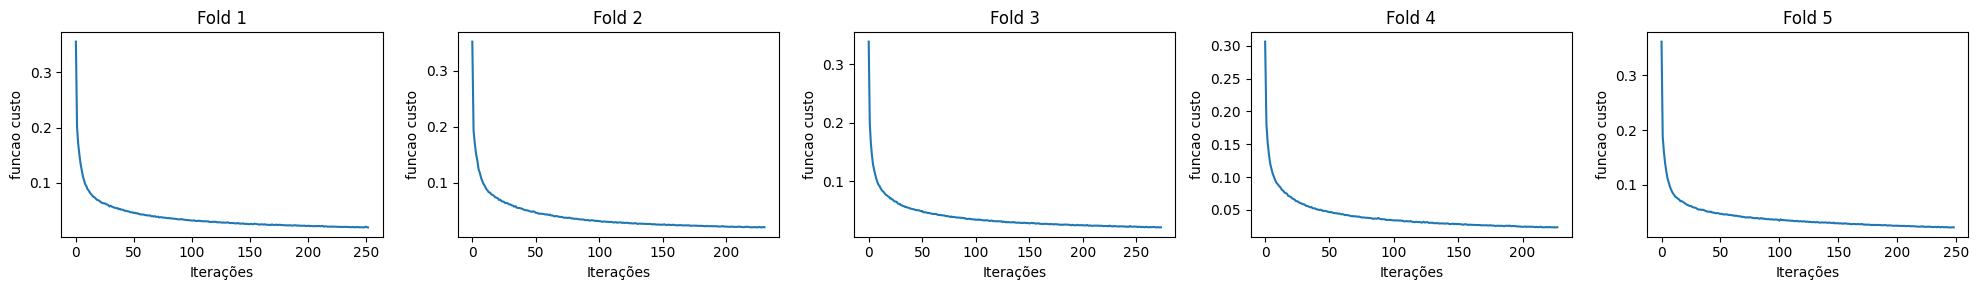

In [7]:
model = MLPRegressor()
kfold_padrao(model=model, hyperparameters= melhores_hiperparametros, features_data= X_train, label_data= y_train, num_folds= 5)

### Testar o modelo para os dados de teste também

In [8]:
y_teste = np.array(y_teste)

model = MLPRegressor(**dict(melhores_hiperparametros))
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train_normalizado = pd.DataFrame(scaler_x.fit_transform(X_train), columns= X_train.columns)
X_teste_normalizado = pd.DataFrame(scaler_x.transform(X_teste), columns= X_teste.columns)
y_train_normalizado = scaler_y.fit_transform(np.array(y_train).reshape(-1, 1)).ravel()
model.fit(X_train_normalizado, y_train_normalizado)
predictions = model.predict(X_teste_normalizado)
predictions_desnormalizadas = scaler_y.inverse_transform(predictions.reshape(-1,1)).ravel()


Cálculo das metricas

In [9]:
rmse = np.sqrt(np.mean((predictions_desnormalizadas - y_teste)**2 )) 
print(f'rmse do modelo eh igual a {rmse}')

rmse do modelo eh igual a 4.734711153512163


In [10]:
mae = np.mean(np.abs(predictions_desnormalizadas - y_teste))
print(f'mean absolute error do modelo eh {mae}')

mean absolute error do modelo eh 3.699753561927741


In [11]:
mre = np.mean(np.abs( (predictions_desnormalizadas -y_teste)/y_teste))
print(f'mean relative error do modelo eh {mre}')

mean relative error do modelo eh 0.12686165021536477


## Questão 2

### Encontrar o melhor conjunto de hiperparametros

In [12]:
data_2 = pd.read_csv('vowel.csv')
data_2 = data_2.sample(frac =1).reset_index(drop= True)
train, test = train_test_split(data_2, test_size= 0.2)

X_train = train.iloc[:, :-1]
y_train = train.iloc[:,-1].astype('int')
X_teste = test.iloc[:, :-1]
y_teste = test.iloc[:, -1].astype('int')

data_2

,col1,col2,col3,col4,col,col5,col6,col7,col8,col9,label
0,-2.851,1.412,-0.184,1.281,0.000,-0.146,-0.172,-0.419,-0.307,0.874,1.0
1,-2.972,1.151,-0.293,1.609,-0.724,0.123,-0.087,-0.801,0.040,1.070,1.0
2,-4.717,3.059,-0.682,0.532,-0.480,0.731,0.174,0.493,0.635,-0.473,10.0
3,-2.652,2.156,-0.053,1.694,-1.258,0.062,-0.610,1.397,0.133,0.602,3.0
4,-2.797,2.706,-1.936,0.147,-0.921,1.240,-0.082,-0.006,-0.214,-0.064,5.0
...,...,...,...,...,...,...,...,...,...,...,...
985,-4.283,2.829,0.296,0.086,-0.544,0.501,-0.317,0.995,-0.340,-1.113,10.0
986,-4.138,1.128,-0.601,1.553,-0.019,2.039,-0.176,0.262,-0.551,-0.362,10.0
987,-2.676,1.411,-0.098,1.047,-0.040,-0.131,-0.560,-0.030,-0.192,0.705,1.0
988,-4.094,3.586,-0.845,-0.026,-0.538,0.964,0.666,0.647,-0.412,-0.477,4.0


In [ ]:
hyperparameter_list = [
    ("learning_rate_init", [0.01, 0.1]),
    ('momentum', [0.8, 0.9]),
    ('batch_size', [10, 20, 40]),
    ('hidden_layer_sizes', [(20,), (50,), (100,)]),
    ('max_iter', [1000]),
    ("activation", ['relu', 'tanh']), 
    ("solver", ['sgd'])
]

melhores_hiperparametros, acuracia_melhor_modelo = kfold_com_grid_search(model = MLPClassifier(), features_data= X_train, label_data= y_train , hyperparameters_list= hyperparameter_list, num_folds= 5)

In [14]:
print(acuracia_melhor_modelo)

0.9521044992743105


Assim como na primeira questão apenas plotei as curvas de aprendizado do modelo com melhor desempenho, por questões de espaço e pela quantidade de combinações possíveis.

In [15]:
print(melhores_hiperparametros)

(('learning_rate_init', 0.1), ('momentum', 0.8), ('batch_size', 40), ('hidden_layer_sizes', (50,)), ('max_iter', 1000), ('activation', 'relu'), ('solver', 'sgd'))


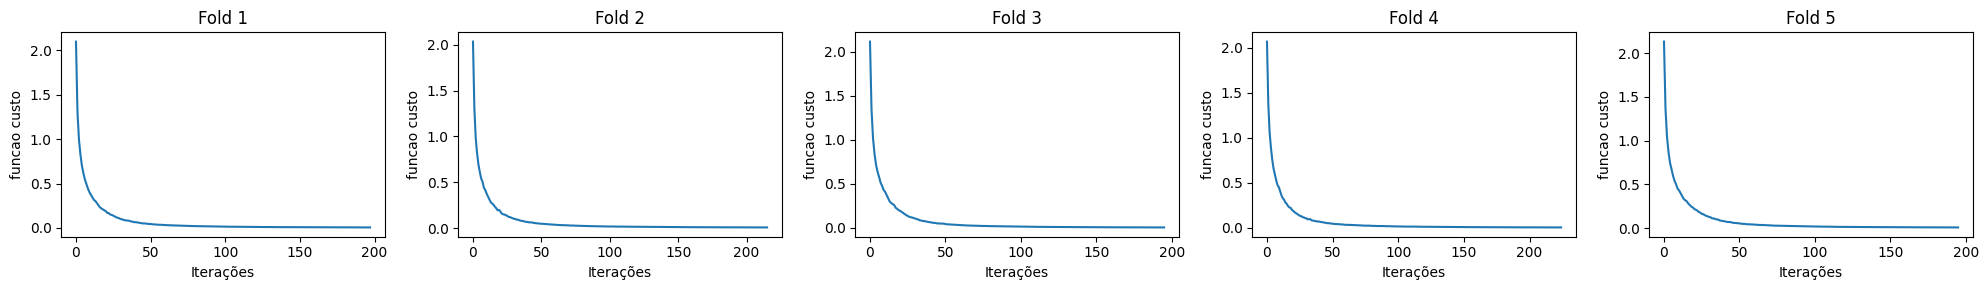

In [16]:
kfold_padrao(model = MLPClassifier(), hyperparameters= melhores_hiperparametros, features_data= X_train, label_data= y_train, num_folds= 5)

### Testar o modelo para os dados de teste também

In [17]:
model = MLPClassifier(**dict(melhores_hiperparametros))

scaler_x = StandardScaler()
X_train_normalizado = pd.DataFrame(scaler_x.fit_transform(X_train), columns= X_train.columns)
X_teste_normalizado = pd.DataFrame(scaler_x.transform(X_teste), columns= X_teste.columns)
model.fit(X_train_normalizado, y_train)
predictions = model.predict(X_teste_normalizado)

Cálculo da acurácia para os dados de teste

In [18]:
acuracia = np.mean(y_teste == predictions)
print(f'a acuracia do modelo eh {acuracia}')

a acuracia do modelo eh 0.9646464646464646
